In [1]:
import h5netcdf
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv
import os
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import cartopy.crs as ccrs
import cartopy.util as cutil
import xarray as xr
from matplotlib import animation
from matplotlib import cm
import string
from scipy.integrate import quad
import matplotlib.colors as mcolors
import matplotlib.backends.backend_pdf
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size'   : 9})
rc('text', usetex=True)
import matplotlib.backends.backend_pdf


In [2]:

names = ['Tasman', 'Indonesian', 'Drake', 'Panama','Thetys']
values = [
    [('x',81,3,9),('y',18,76,78),('x', 27,3,6), 0, 0], # 0Ma
    [('x',81,3,9),('y',17,74,78),('x',27,3,6), 0, 0], # 5 Ma
    [('x',81,3,9),('y',18,74,78),('x',27,3,6), ('y', 21,25,27), 0], # 10 Ma open panama
    [('x',81,3,9),('y',18,74,78),('x',27,3,6), ('y', 21,25,27), ('x',50,20,30)], # 15 Ma open panama
    [('x',81,3,9),('x',75, 10, 20),('x',28,3,6), ('y',  20,25,28), ('x',50,20,30)], # 20 Ma 
    [('x',81,3,9),('x',75, 10, 20),('x',28,3,6), ('y',  20,25,28), ('x',50,20,30)], # 25 Ma 
    [('x',82,3,9),('x',75, 10, 19),('x',29,3,6), ('y',  20,25,29), ('x',50,20,30)], # 30 Ma
    [('x',82,3,9),('x',76, 16, 21),0, ('y',  20,26,28), ('x',50,20,30)], # 35 Ma drake closure
    [0,('x',76, 15, 20),0, ('y',  20,26,29), ('x',50,20,30)], # 40 Ma Tasman closure
    [0,('x',76, 15, 20),0, ('y',  20,25,29), ('x',50,20,30)], # 45 Ma
    [0,('x',76, 15, 20),0, ('x',  28, 18,23), ('x',50,20,30)], # 50 Ma
    [0,('x',77, 14, 20),0, ('x',  28, 18,25), ('x',50,20,30)], # 55 Ma
    [0,('x',77, 14, 19),0, ('x',  28, 19,23), ('x',50,20,30)], # 60 Ma
    [0,('x',77, 11, 20),0, ('x',  30, 21,24), ('x',50,20,30)], # 65 Ma
]

In [3]:
time = np.arange(0,70,5)
print(time)
rundir = '../../actual_runs/runs_4_degree_with_customdeep/'

yearsdone = []
ranfory = []
xt = []
yt = []
zt = [] 

xu = []
yu = []
dzt = []
dyt = []
dxt = []
dyu = []

u = []
area_u = []
v = []
area_v = []

for year in time:
    if os.path.exists(rundir + 'Run%i/run_%ima.current_run' % (year,year)):
        with open(rundir + 'Run%i/run_%ima.current_run' % (year,year)) as f:
            ranfor = int(f.readline())
        ranfory.append(ranfor)
        yearsdone.append(year)
        with xr.open_dataset(rundir + 'Run%i/run_%ima.%04d.averages.nc'% (year,year,ranfor -1)) as ds:
            u.append(ds['u'].values) 
            v.append(ds['v'].values)
            if xt == []:
                xt = ds['xt'].values
                yt = ds['yt'].values
                zt = ds['zt'].values
                xu = ds['xu'].values
                yu = ds['yu'].values
        with xr.open_dataset(rundir + 'Run%i/run_%ima.%04d.snapshot.nc'% (year,year,ranfor -1)) as ds:
            area_u.append(ds['area_u'].values)
            area_v.append(ds['area_v'].values)
            if dzt == []:
                dzt = ds['dzt'].values
                dyt = ds['dyt'].values
                dxt = ds['dxt'].values
                dyu = ds['dyu'].values

radearth = 6371000
torad = np.pi/180.0

dzts = np.flip(radearth - np.append(0,np.cumsum(dzt[::-1])))

zy_area = -np.repeat([[quad(lambda r: r*(4)*torad, dzts[i], dzts[i+1])[0] for i in range(dzt.shape[0])]],repeats=40, axis=0)


# zx area

area = np.array(area_u)[-1]
dxt_array = np.array([a / dyt[0]  for i, a in enumerate(area)])
dxt_array = np.array([np.nanmax(a) for a in dxt_array])/radearth


zx_area =-np.array([[quad(lambda r: r*theta*torad, dzts[i], dzts[i+1])[0] for i in range(dzt.shape[0])] for theta in dxt_array])


[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65]


In [4]:
u = np.array(u)
def calctf_X(time,long, minlat, maxlat):
    zonalu = u[time,0,:,minlat:maxlat,long]
    area = np.transpose(zy_area[minlat:maxlat])

    throughflow = area * zonalu
    
    return np.nansum(throughflow)
def calctf_Y(time,lat, minlong, maxlong):
    zonalu = u[time,0,:,lat,minlong:maxlong]
    area = zx_area[lat]
    
    throughflow = np.array([a * zonu for a, zonu in zip(area,zonalu)])
    
    return np.nansum(throughflow)

def calctf(long, minlat, maxlat):
    zonarr = u[0,0,:,minlat:maxlat,long]

    def area(z0, z1, lat0, lat1):
        torad = np.pi/180.0
        rad0 = lat0*torad
        rad1 = lat1*torad

        return quad(lambda r: r*(rad0 - rad1), z0, z1)


    radearth = 6371000

    areaarr = np.zeros(zonarr.shape)

    throughflow = np.zeros(zonarr.shape)

    maxz = 0
    for zi, z in enumerate(zonarr):
        for yi, y in enumerate(z):
            if zi == 14:
                maxz = radearth
            else:
                maxz = radearth + zt[zi+1]

            areaarr[zi,yi], _ = area(radearth + zt[zi], maxz, 4,0)
            throughflow[zi,yi] = areaarr[zi,yi] * y
    
    
    return np.nansum(throughflow)


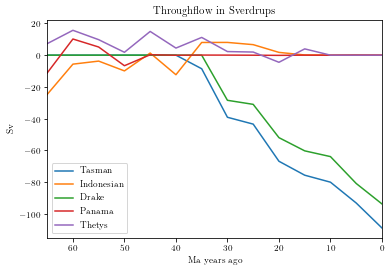

In [6]:
tf_values = np.zeros(np.shape(values))

for y, year in enumerate(values):
    for p, passage in enumerate(year):
        if not isinstance(passage,tuple):
            continue
        if passage[0] == 'x':
            tf_values[y,p] = calctf_X(y,passage[1],passage[2],passage[3]) /1e6
        if passage[0] == 'y':
            tf_values[y,p] = calctf_Y(y,passage[1],passage[2],passage[3]) / 1e6

for i,tf_val in enumerate(np.transpose(tf_values)):
    plt.plot(time,tf_val,label=names[i])
plt.legend()
plt.title(r"Throughflow in Sverdrups")
plt.xlabel(r"Ma years ago")
plt.ylabel(r"Sv")
plt.xlim(65,0)
plt.savefig("../figures/throughflow.jpg")
plt.show()